In [ ]:
# This notebook is a copy similar to ALR_Client_Side found in:
# https://github.com/rfernand387/ALR_Earth_Engine/blob/master/ALR_Client_Side.ipynb

# Modifications have been made to accept an EE image with 10 m resolution bands that has been outputted from SL2P10_control.ipynb:
# https://github.com/kateharvey/Sentinel2_ALR/blob/main/shared/SL2P10_control.ipynb

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import ee
import json
from collections import OrderedDict
import time
import math
import csv
import os

In [2]:
ee.Authenticate()

Enter verification code:  4/1AX4XfWjwsICzVF6hlIwYmx8sSUoEqfddU1P40CFnkv33UP0V-HqCnzgwiKM



Successfully saved authorization token.


In [3]:
# Authorize the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [106]:
# Set the test image using an uploaded asset for now
inputImageCollection = ee.ImageCollection('users/kateharvey/test_collection')
inputImage = ee.Image(inputImageCollection.toList(inputImageCollection.size()).get(2))

# Change variable name here to match band name pattern (one of: Albedo, fAPAR, fCOVER, LAI, CCC, CWC, DASF)
outputName = 'LAI'
defaultBand = 'estimate'+outputName

# List the bands that we expect in the image (ensure number of bands in the list below matches the number bands in the input image)
# This is the order of bands produced by running SL2P10 and exporting the resulting ImageCollection
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'date', 'QC', 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'])

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [107]:
# Below we define a list of strings representing the expressions for each vegetation index as a function of the bands in the input image
# More vegetation indices can be defined, but the list CANNOT contain any two vegetation indices which are a linear combination of each
# other or LARs will fail to select the requested number of variables

# The formatting of the expression must be
# "<name of VI> = <expression with band names from inputImage_bands used as variables in the form b('<band name>')"

# Only include VIs that use 10 m bands (B2, B3, B4, B8)
input_VI_definition = ee.List(["RAW_B2  = b('B2')",
                               "RAW_B3  = b('B3')",
                               "RAW_B4  = b('B4')",
                               "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

In the following functions each input is recast to the expected data type as function parameter typing is not enforced in Earth Engine
when defining functions, and later methods called on these parameters within the function must recognize the type of the parameter
independently of other code

In [108]:
# The following function takes an image, a list of strings for the names of the bands in the image to rename to, a string which is the 
# name of the band containing the response variable in the image, and the list of strings defining vegetation indices to add to the image.
# It returns an image which contains all of the original bands in the image renamed and all of the vegetation indices defined earlier
# with the response band being the last band defined in the image
def format_image(image, image_bands, response_band, VI_definition):
    image = ee.Image(image)
    image_bands = ee.List(image_bands)
    response_band = ee.String(response_band)
    VI_definition = ee.List(VI_definition)
    
    # image_bands specifices a list of the names of the bands used in defining the expressions for VIs in VI_definition
    image = image.rename(image_bands).toDouble()
    
    # Generate an imageCollection from a list of expressions defining a set of Vegetation Indices using the bands available in the image
    VIimageCollection = ee.ImageCollection(VI_definition.map(lambda expr: image.expression(expr)))
    VIimage = VIimageCollection.toBands().regexpRename("[0-9]+_", "")
    
    # Reorder the bands in the image so the response band is the last band in the image
    feature_bands = image_bands.remove(response_band)
    
    return image.select(feature_bands).addBands(VIimage).addBands(image.select(response_band))

In [109]:
# The following function takes an image and retrieves the total number of pixels in the image as an integer
def get_num_pixels(image):
    image_dimensions = ee.List(image.getInfo()["bands"][28]["dimensions"])
        # 28 is the index of the last band using the inputs defined above (12 input bands plus 17 VIs = 29 total bands)
    image_height = image_dimensions.getNumber(0)
    image_width = image_dimensions.getNumber(1)
    image_pixels = image_height.multiply(image_width)
    
    return image_pixels

In [110]:
# The following function takes an image and a string which is the name of the band containing the response variable in the image
# It returns an image with the response band centred to a mean 0, and the other bands in the image standardized to a mean 0 and a 
# standard deviation of 1. This preprocessing is necessary for the LARs algorithm
def scale_image(image, response_band):
    image = ee.Image(image)
    response_band = ee.String(response_band)
    image_pixels = ee.Number(get_num_pixels(image))
    
    # Set up lists containing the input/feature bands in the image
    bandList = image.bandNames()
    featureList = bandList.remove(response_band)
    num_bands = bandList.length()
    num_features = featureList.length()
    
    # We will be using the reduceRegion() function on images from Earth Engine, 
    # which will process up to a specified number of pixels from the image to generate the outputs of the reducer
    max_pixels = image_pixels.min(10000000)
    # best_effort = ee.Algorithms.If(image_pixels.gt(max_pixels), True, False)
    
    # Set default projection and scale using the response band
    defaultScale = image.select(defaultBand).projection().nominalScale()
    defaultCrs = image.select(defaultBand).projection().crs()
    image = image.setDefaultProjection(crs=defaultCrs, scale=defaultScale)
    
    # Center all of the bands in the image for LARs, we will centre the sampled data later as well as reduceRegion() is not precise enough
    meanImage = image.subtract(image.reduceRegion(reducer=ee.Reducer.mean(), scale=defaultScale, bestEffort=True, maxPixels=max_pixels).toImage(bandList))
    
    # Separate the image into features (X) and response (y) as we need to standardize the input features
    X = meanImage.select(featureList)
    y = meanImage.select(response_band)
    
    # Standardize the input features
    X = X.divide(X.reduceRegion(reducer=ee.Reducer.stdDev(), bestEffort=True, maxPixels=max_pixels).toImage(featureList))
    
    return X.addBands(y)

In [143]:
# The following function implements the LARs algorithm fully as described in (et al. 2002)
# It takes an image, a string which is the name of the band containing the response variable in the image, the number of non-zero
# coefficients requested for the LARs algorithm to select the best features to predict the response in the image
# Additionally the function requires the number of samples (pixels) from the image that the user wishes to process. 
# These inputs are necessary as Earth Engine provides a limited amount of RAM (2GB) and processing time on their virtual machines,
# so the user may need to adjust how many pixels they wish to process in the image in case the function leads to a 
# "User memory limit exceeded error" or "Computation timed out error"
def ee_LARS(image, response_band, num_nonzero_coefficients, num_samples):
    image = ee.Image(image)
    response_band = ee.String(response_band)
    num_nonzero_coefficients = ee.Number(num_nonzero_coefficients)
    num_samples = ee.Number(num_samples)
    image_pixels = ee.Number(get_num_pixels(image))

    # Retrieve the list of features in the image by getting all of the band names and removing the response band name from the list
    bandList = image.bandNames()
    featureList = bandList.remove(response_band)
    
    # Randomly sample pixels in the image at its native resolution into a feature collection
    # (either as many as requested in the function call, or all of the pixels in the image if the total number of pixels in the image 
    # is less than the number of samples requested) 
    inputCollection = image.sample(numPixels=num_samples.min(image_pixels))
    n = inputCollection.size()
    m = featureList.length()
    
    # Use an aggregate array function over the feature collection and map the function over each feature in the band list
    # to generate a dictionary of all of the samples retrieved
    inputs = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_array(feature)))
    
    # Although we may call our scale_image function on the input image, the reduceRegion() function used to determine the mean
    # and standard deviation of each band in the image over the entire region is not precise enough over a large image
    # so we must recenter all of the bands in the image and now we can also normalize (L2 norm) each input feature as is required
    # by the LARs algorithm
    
    # Use an aggregate_mean function over the feature collection to get the mean of each band
    input_means = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_mean(feature)))

    # Center all of the bands in the image by mapping a function over the list of features and then a subtract over the list of all samples for each band
    def centre_inputs(key, value):
        key_mean = input_means.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).subtract(key_mean))
    inputs = inputs.map(centre_inputs)
    
    # Separate the response variable samples into its own vector
    y = inputs.toArray([response_band]).reshape([-1,1])
    
    # Remove response band from the feature collection by selecting only bands in the feature list
    inputs = inputs.select(featureList)
    
    # Generate a dictionary of all of the L2 norms of the input features using a custom mapped function
    input_norms = inputs.map(lambda key, value: ee.Number(ee.List(value).map(lambda sample: ee.Number(sample).pow(2)).reduce(ee.Reducer.sum())).pow(0.5))
    
    # Normalize all of the features by mapping a function over the list of features and then map a division over the list of all of the samples of the feature
    def norm_inputs(key, value):
        key_norm = input_norms.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).divide(key_norm))
    inputs = inputs.map(norm_inputs)
    
    # Generate the array of samples using the dictionary
    X = inputs.toArray(featureList).transpose()
    
    # Find the first best predictor of the response to initialize the main LARs loop
    initial_prediction = ee.Array(ee.List.repeat([0], n))
    c = X.transpose().matrixMultiply(y.subtract(initial_prediction))
    c_abs = c.abs()
    C_maxLoc = c_abs.project([0]).argmax()
    add_feature = C_maxLoc.getNumber(0)
    A = ee.List([add_feature])
    
    # Create a dicitionary of initial inputs to pass into the main LARs iterative loop
    # The iterate function in Earth Engine processes each iteration as a tree of iterations with no access to any variables
    # from previous iterations, only those that are passed to the next iteration, so we must pass both the current prediction and
    # the active set of features (with non-zero coefficients), A
    initial_inputs = ee.Dictionary({'prediction': initial_prediction, 'A': A})
    
    def LARs_regression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        
        # Find the active set of features, A (predictors with non-zero coefficients)
        A = ee.List(inputs.get('A'))
        # A_list is an array used to mask the full array of input samples and the correlation vector
        A_list = ee.Array(ee.List.sequence(0, m.subtract(1)).map(lambda index: A.contains(index)).replaceAll(False, 0).replaceAll(True, 1)).reshape([-1,1])
        
        # The following matrix algebra determines the next most correlated variable, or the next best predictor considering the
        # current features in the active set, A, as well as the magnitude to adjust the prediction vector to ensure all of the features
        # in the active set are equally correlated to response vector
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())
        s_A = c.divide(c_abs).mask(A_list)
        X_A = X.mask(A_list.transpose())
        G_Ai = X_A.transpose().matrixMultiply(X_A).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X_A.matrixMultiply(w_A)
        a = X.transpose().matrixMultiply(u_A)
        a = a.project([0])
        c = c.project([0])
        
        def compute_gammaArray(index_j):
            minus_j = C_max.subtract(c.get([index_j])).divide(A_A.subtract(a.get([index_j])))
            plus_j = C_max.add(c.get([index_j])).divide(A_A.add(a.get([index_j])))
            return ee.List([minus_j, plus_j]).filter(ee.Filter.gte('item', 0)).reduce(ee.Reducer.min())
        
        A_c = ee.List.sequence(0, m.subtract(1)).removeAll(A)
        gammaArray = A_c.map(compute_gammaArray)
        gamma = gammaArray.reduce(ee.Reducer.min())
        min_location = gammaArray.indexOf(gamma)
        add_feature = A_c.getNumber(min_location)
        
        # Update our active set of variables with the next best predictor from the non-active set and update the prediction vector
        A = A.add(add_feature)
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    # For the final iteration of LARs(if selecting all of the input variables) we require a different method to determine the magnitude
    # to adjust the magnitude of the prediction vector, as the regular LARs iteration relies on the variables in the non-active set
    # In the final iteration there will be no variables in the non-active set, so the method will not work
    def LARs_final_iteration(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        A = ee.List(inputs.get('A'))
        
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())        
        
        s_A = c.divide(c_abs)
        G_Ai = X.transpose().matrixMultiply(X).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X.matrixMultiply(w_A)
        
        gamma = C_max.divide(A_A)
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    # Actually carrying out the iterations by iterating over a placeholder list which is a sequence from 1 to the number of non-zero
    # variables that the user wishes to select as predictors for the response
    iterations = ee.List.sequence(1, m.subtract(1).min(num_nonzero_coefficients))
    penultimate_outputs = iterations.iterate(LARs_regression, initial_inputs)
    final_outputs = ee.Dictionary(ee.Algorithms.If(num_nonzero_coefficients.gte(m), LARs_final_iteration(m, penultimate_outputs), penultimate_outputs))
    
    final_prediction = final_outputs.getArray('prediction')
    A = ee.List(final_outputs.get('A'))
    feature_path = A.slice(0, num_nonzero_coefficients).map(lambda index: featureList.getString(index))
    
    # The code snippet below is able to extract the exact coefficients on all of the selected features, but is commented out
    # as it adds computational complexity that takes up unnecessary memory on the Google Earth Engine virtual machine since we
    # are only using LARs as a feature selection algorithm

#     coefficients = X.matrixSolve(final_prediction).project([0]).toList().map(lambda num: ee.Algorithms.If(ee.Number(num).abs().lt(0.001), 0, num))
#     print('Coefficients')
#     coeff = ee.Dictionary.fromLists(featureList, coefficients).getInfo()
#     ordered_coeff = OrderedDict()
#     var_path = feature_path.cat(featureList.removeAll(feature_path)).getInfo()
#     for key in var_path:
#         ordered_coeff[key] = coeff[key]
#     print(json.dumps(ordered_coeff, indent=1))

    return feature_path #.getInfo()

In [112]:
# The following function trims input data according to an algorithm in which the response band is partitioned into n equally sized
# partitions, and in each of the n partitions, for the features selected by LARs, they are each trimmed individually down to only the
# 5-95 percentile of the data. We are not doing any preprocessing with the data, so the raw data is exported from Earth Engine
# The function takes an image, a list of strings with the selected feature bands in the image, the string that is the name of the response
# band in this image, the number of samples/pixels the user wants to take from the image, and the number of parititions to trim within
def trim_data(image, selected_features, response_band, num_samples, num_partitions):
    image = ee.Image(image)
    selected_features = ee.List(selected_features)
    response_band = ee.String(response_band)
    num_samples = ee.Number(num_samples)
    num_partitions = ee.Number(num_partitions)
    
    # Generate the list of percentile bounds for the requested number of partitions, and the names of the value bounds for the
    # dictionary that will be generated from the percentile reducer used later on
    percentiles = ee.List.sequence(0, 100, ee.Number(100).divide(num_partitions))
    percentile_names = percentiles.map(lambda num: ee.Number(num).round().toInt().format("p%s"))
    
    # Randomly sample the pixels in the input image into a feature collection containing only the selected features and the response
    image_pixels = ee.Number(get_num_pixels(image))
    inputsCollection = image.select(selected_features.add(response_band)).sample(numPixels=num_samples.min(image_pixels))
    
    # Find the values at the percentile bounds using the percentile reducer over the feature collection
    response_percentiles = inputsCollection.reduceColumns(ee.Reducer.percentile(percentiles=percentiles, outputNames=percentile_names, maxRaw=inputsCollection.size()), [response_band])
    
    # Create a list of percentile bounds for each partition
    response_partitions = response_percentiles.values(percentile_names.remove('p100')).zip(response_percentiles.values(percentile_names.remove('p0')))
    
    # We'll use the following function mapped over the response_partitions list to partition the data by the requested number of partitions
    def partition_data(partition_range):
        partition_range = ee.List(partition_range)
        return inputsCollection.filter(ee.Filter.rangeContains(response_band, partition_range.getNumber(0), partition_range.getNumber(1)))
    
    partitioned_data = response_partitions.map(partition_data)
    
    # The following function now trims the data in each partition individually for each feature to its 5-95 percentile only
    def trim_partitions(partition):
        partition = ee.FeatureCollection(partition)
        feature_trimming_bounds = selected_features.map(lambda feature: ee.List([feature]).cat(partition.reduceColumns(ee.Reducer.percentile([5, 95]), [feature]).values(['p5','p95'])))
        def trimmer(current_feature, collection):
            current_feature = ee.List(current_feature)
            collection = ee.FeatureCollection(collection)
            return collection.filter(ee.Filter.rangeContains(current_feature.getString(0), current_feature.getNumber(1), current_feature.getNumber(2)))
        return feature_trimming_bounds.iterate(trimmer, partition)
    
    # Retrieve the trimmed data partitions and flatten the paritions into a single trimmed feature collection
    trimmed_partitions = partitioned_data.map(trim_partitions)
    trimmed_data = ee.FeatureCollection(trimmed_partitions).flatten()
    
    return trimmed_data

In [113]:
def elu(x):
    return x if x>=0 else (math.exp(x)-1)

In [114]:
def softplus(x):
    return math.log(math.exp(x)+1)

In [115]:
def softsign(x):
    return x/(abs(x)+1)

In [116]:
def relu(x):
    return max(x, 0.0)

In [117]:
def tanh(x):
    return (math.exp(2*x)-1)/(math.exp(2*x)+1)

In [118]:
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [119]:
def apply_nnet(inputs, keras_model):
    
    for layer in keras_model.layers:
        layer_weights = layer.get_weights()
        node_weights = layer_weights[0]
        bias = layer_weights[1]
        
        inputs = inputs.dot(node_weights)+bias
        
        activation_function = layer.get_config()["activation"]
        if(activation_function != "linear"):
            activation_function = activation_functions[activation_function]
            
            inputs = activation_function(inputs)
            
    return inputs

In [120]:
# The following function exports the keras model in a way that can be parsed into a feature collection in Earth Engine and applied to images manually

def export_nnet(keras_model):
    nnet_data = []
    headers = []
    prev_layer_size = len(X.keys())
    layer_num = 0
    
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation_function = layer_info["activation"]
        layer_weights = layer.get_weights()[0]
        layer_bias = layer.get_weights()[1]
        
        headers = list(set(headers) | set([x for x in range((prev_layer_size+1)*num_nodes)]))
        
        layer_data = [0, 0, layer_num, prev_layer_size, num_nodes, activation_function] + layer_weights.flatten().tolist() + layer_bias.tolist()
        nnet_data.append(layer_data)
        
        prev_layer_size = num_nodes
        layer_num += 1
    
    nnet_data.insert(0, ["latitude", "longitude", "layer_num", "prev_layer_size", "num_nodes", "activation"]+headers)
    return nnet_data

In [121]:
inputImage = format_image(inputImage, inputImage_bands, defaultBand, input_VI_definition)

In [122]:
num_input_pixels = get_num_pixels(inputImage)

In [123]:
scaledImage = scale_image(inputImage, defaultBand)

In [124]:
select_features = ee_LARS(scaledImage, defaultBand, 5, num_input_pixels)

In [125]:
# Creating the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
exportData = ee.batch.Export.table.toDrive(collection=trim_data(image=inputImage, selected_features=select_features, response_band="estimateLAI", num_samples=50000, num_partitions=10),
                                           description="image_data_samples",
                                           fileFormat="CSV")

In [126]:
# Starting the export data task
exportData.start()

In [127]:
# Essentially a wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


In [128]:
# Reading the CSV file into pandas dataframes
trimmed_data = pandas.read_csv('./gdrive/image_data_samples.csv')
X = trimmed_data.drop(labels=['LAI', 'system:index', '.geo'], axis=1)
y = trimmed_data.LAI

In [129]:
# We preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pandas.DataFrame(sklearn.preprocessing.scale(X))

In [130]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(5, input_shape=[len(X.keys())]),
    tensorflow.keras.layers.Dense(4, activation="softsign"),
    tensorflow.keras.layers.Dense(3, activation="softsign"),
    tensorflow.keras.layers.Dense(2, activation="softsign"),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [131]:
# Fitting the model to our trimmed data
LAI_model.fit(x = X.to_numpy(), y = y.to_numpy(), epochs = 100)

Epoch 1/100
1143/1143 [==============================] - 5s 3ms/step - loss: 0.6305 - mse: 0.6305 - mae: 0.5999
Epoch 2/100
1143/1143 [==============================] - 4s 4ms/step - loss: 0.0766 - mse: 0.0766 - mae: 0.1990
Epoch 3/100
1143/1143 [==============================] - 3s 3ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1678
Epoch 4/100
1143/1143 [==============================] - 3s 2ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1618
Epoch 5/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1616
Epoch 6/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1590
Epoch 7/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1577
Epoch 8/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1544
Epoch 9/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0405 - mse: 0.0405 - mae:

In [132]:
# Predicting our own input data to evaluate the performance (for now)
LAI_predictions = pandas.Series(LAI_model.predict(X.to_numpy()).flatten())

In [133]:
xy_tf_LAI = numpy.vstack([y, LAI_predictions])

In [134]:
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [135]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [136]:
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

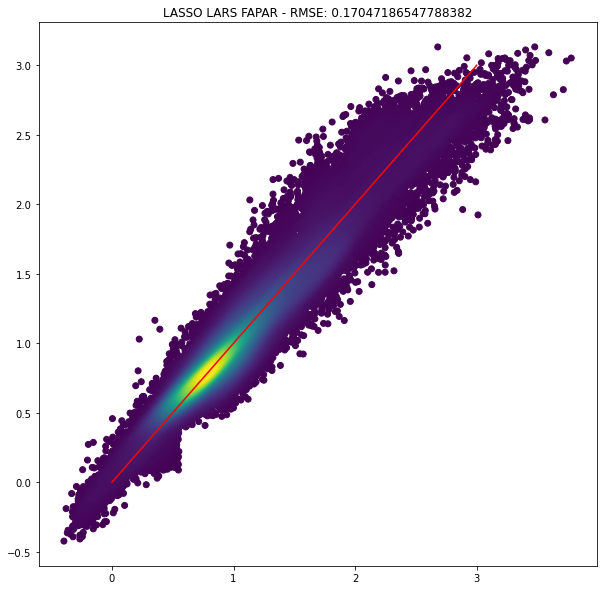

In [137]:
a_tf_LAI = numpy.linspace(0, 3, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.title.set_text('LASSO LARS FAPAR - RMSE: {}'.format(rmse_tf_LAI))

In [138]:
LAI_model.get_weights()

[array([[ 0.09951758, -0.5054577 , -0.16551661,  0.11127148, -0.44174743],
        [-0.144358  , -0.12844765, -0.41933495, -0.46423286, -0.44498143],
        [-0.7148159 ,  0.14332907, -0.4569232 ,  0.29920387,  0.8099754 ],
        [ 0.06662956, -0.11064261, -0.06749546, -0.1073179 , -0.86488086],
        [ 0.18594083,  0.44668865,  0.69852996,  0.56592286,  0.22940218]],
       dtype=float32),
 array([-0.5713684 ,  0.99247533,  0.15314242, -0.6525169 ,  0.46100983],
       dtype=float32),
 array([[-0.40093136,  0.46822926, -0.43458608, -0.58358526],
        [ 0.8842308 ,  0.25037634,  0.10905819,  0.60561824],
        [ 0.8400514 , -0.09501945, -0.0939925 ,  0.11388614],
        [ 0.37133688,  0.7226246 , -0.87840563, -0.11375075],
        [ 0.7381089 , -0.20390296, -0.965807  ,  0.57357085]],
       dtype=float32),
 array([ 0.1330952 , -0.3835525 ,  0.76489365,  0.3649062 ], dtype=float32),
 array([[-1.0440445 , -0.795729  , -0.5972344 ],
        [-0.08756548, -0.47708166, -0.650021

In [139]:
elu = numpy.vectorize(elu)
softplus = numpy.vectorize(softplus)
softsign = numpy.vectorize(softsign)
relu = numpy.vectorize(relu)
tanh = numpy.vectorize(tanh)
sigmoid = numpy.vectorize(sigmoid)

In [140]:
activation_functions = {"elu": elu, "softplus": softplus, "softsign": softsign, "relu": relu, "tanh": tanh, "sigmoid": sigmoid}

In [141]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(apply_nnet(inputs, LAI_model)[0])

0.60522175
0.6052215440580176


In [142]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = export_nnet(LAI_model)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)